In [1]:
import pandas as pd
import numpy as np
# from relative_fitness_mechanisms.selective_pressure_prediction import (create_lagged_features, 
#                                                                        process_inputs_all, 
#                                                                        withhold_test_locations_and_split)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string
import pickle 

In [2]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from selective_pressure_prediction import (create_lagged_features, 
                                           process_inputs_all, 
                                            withhold_test_locations_and_split)
import matplotlib as mpl

np.random.seed(45)

mpl.rcParams["xtick.labelsize"] = 18

In [3]:
selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t")
#selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases.tsv", sep="\t")

selective_pressure_df["date"] = pd.to_datetime(selective_pressure_df["date"])
selective_pressure_df = selective_pressure_df.dropna()

In [4]:
selective_pressure_df["log_smooth_cases"] = np.log(selective_pressure_df["smooth_cases"])

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]

# Create lagged features by group
for loc, group in selective_pressure_df.groupby("location"):
    input_dfs[loc] = create_lagged_features(
        group[keep_features + keep_targets], 
        ["selective_pressure"], 
        28)

In [6]:
WITHHELD_LOCATIONS = ["England"]
dates_vec, locations_vec, X, y = process_inputs_all(input_dfs, target=TARGET)
X_train, y_train, X_test, y_test = withhold_test_locations_and_split(X, y, locations_vec, WITHHELD_LOCATIONS, test_size=0.2)

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [8]:
infer = False
load = True

In [9]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1e-2),
    'Lasso': Lasso(alpha=1e-6),
    'RandomForest': RandomForestRegressor(n_estimators=50),
    'GradientBoostingA': GradientBoostingRegressor(loss="absolute_error", n_estimators=50, max_depth=3),
    'GradientBoostingB': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=5),
    'GradientBoostingC': GradientBoostingRegressor(loss="absolute_error", n_estimators=50, max_depth=3),
    'GradientBoostingD': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=5),
    'GradientBoostingE': GradientBoostingRegressor(loss="absolute_error", n_estimators=50, max_depth=7),
    'GradientBoostingF': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=7),

}
model_scores = {model: [] for model in models}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation for model selection
if infer:
    for train_index, val_index in tscv.split(X_train):
        X_train_split, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_split, y_val = y_train.iloc[train_index].values[:, 0], y_train.iloc[val_index].values[:, 0]

        # Initialize and train your model within each split
        for model_name, model in models.items():
            model.fit(X_train_split, y_train_split)
            predictions = model.predict(X_val)
            mae = mean_absolute_error(y_val, predictions)

            # Append the MAE to the model's list of scores
            model_scores[model_name].append(mae)

    for model_name, scores in model_scores.items():
        print(f"{model_name}: Mean MAE = {np.mean(scores):.4f}, Std MAE = {np.std(scores):.4f}")

    best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))

    with open('../data/posteriors/growth-rate-prediction/model_scores.pkl', 'wb') as f:
        pickle.dump(model_scores, f)

In [10]:
# Loading model scores
if load:
    with open('../data/posteriors/growth-rate-prediction/model_scores.pkl', 'rb') as f:
        model_scores = pickle.load(f)

In [11]:
# Retrain best model
if infer:
    best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train.values[:, 0])
    predictions = best_model.predict(X_test)
    with open('../data/posteriors/growth-rate-prediction/empirical_growth_rate.pkl','wb') as f:
        pickle.dump(best_model,f)

In [12]:
#best_model = models["Lasso"]
#best_model.fit(X, y)

In [13]:
# Loading best model
if load:
    with open('../data/posteriors/growth-rate-prediction/empirical_growth_rate.pkl','rb') as f:
        best_model = pickle.load(f)

In [14]:
model = best_model

In [15]:
TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

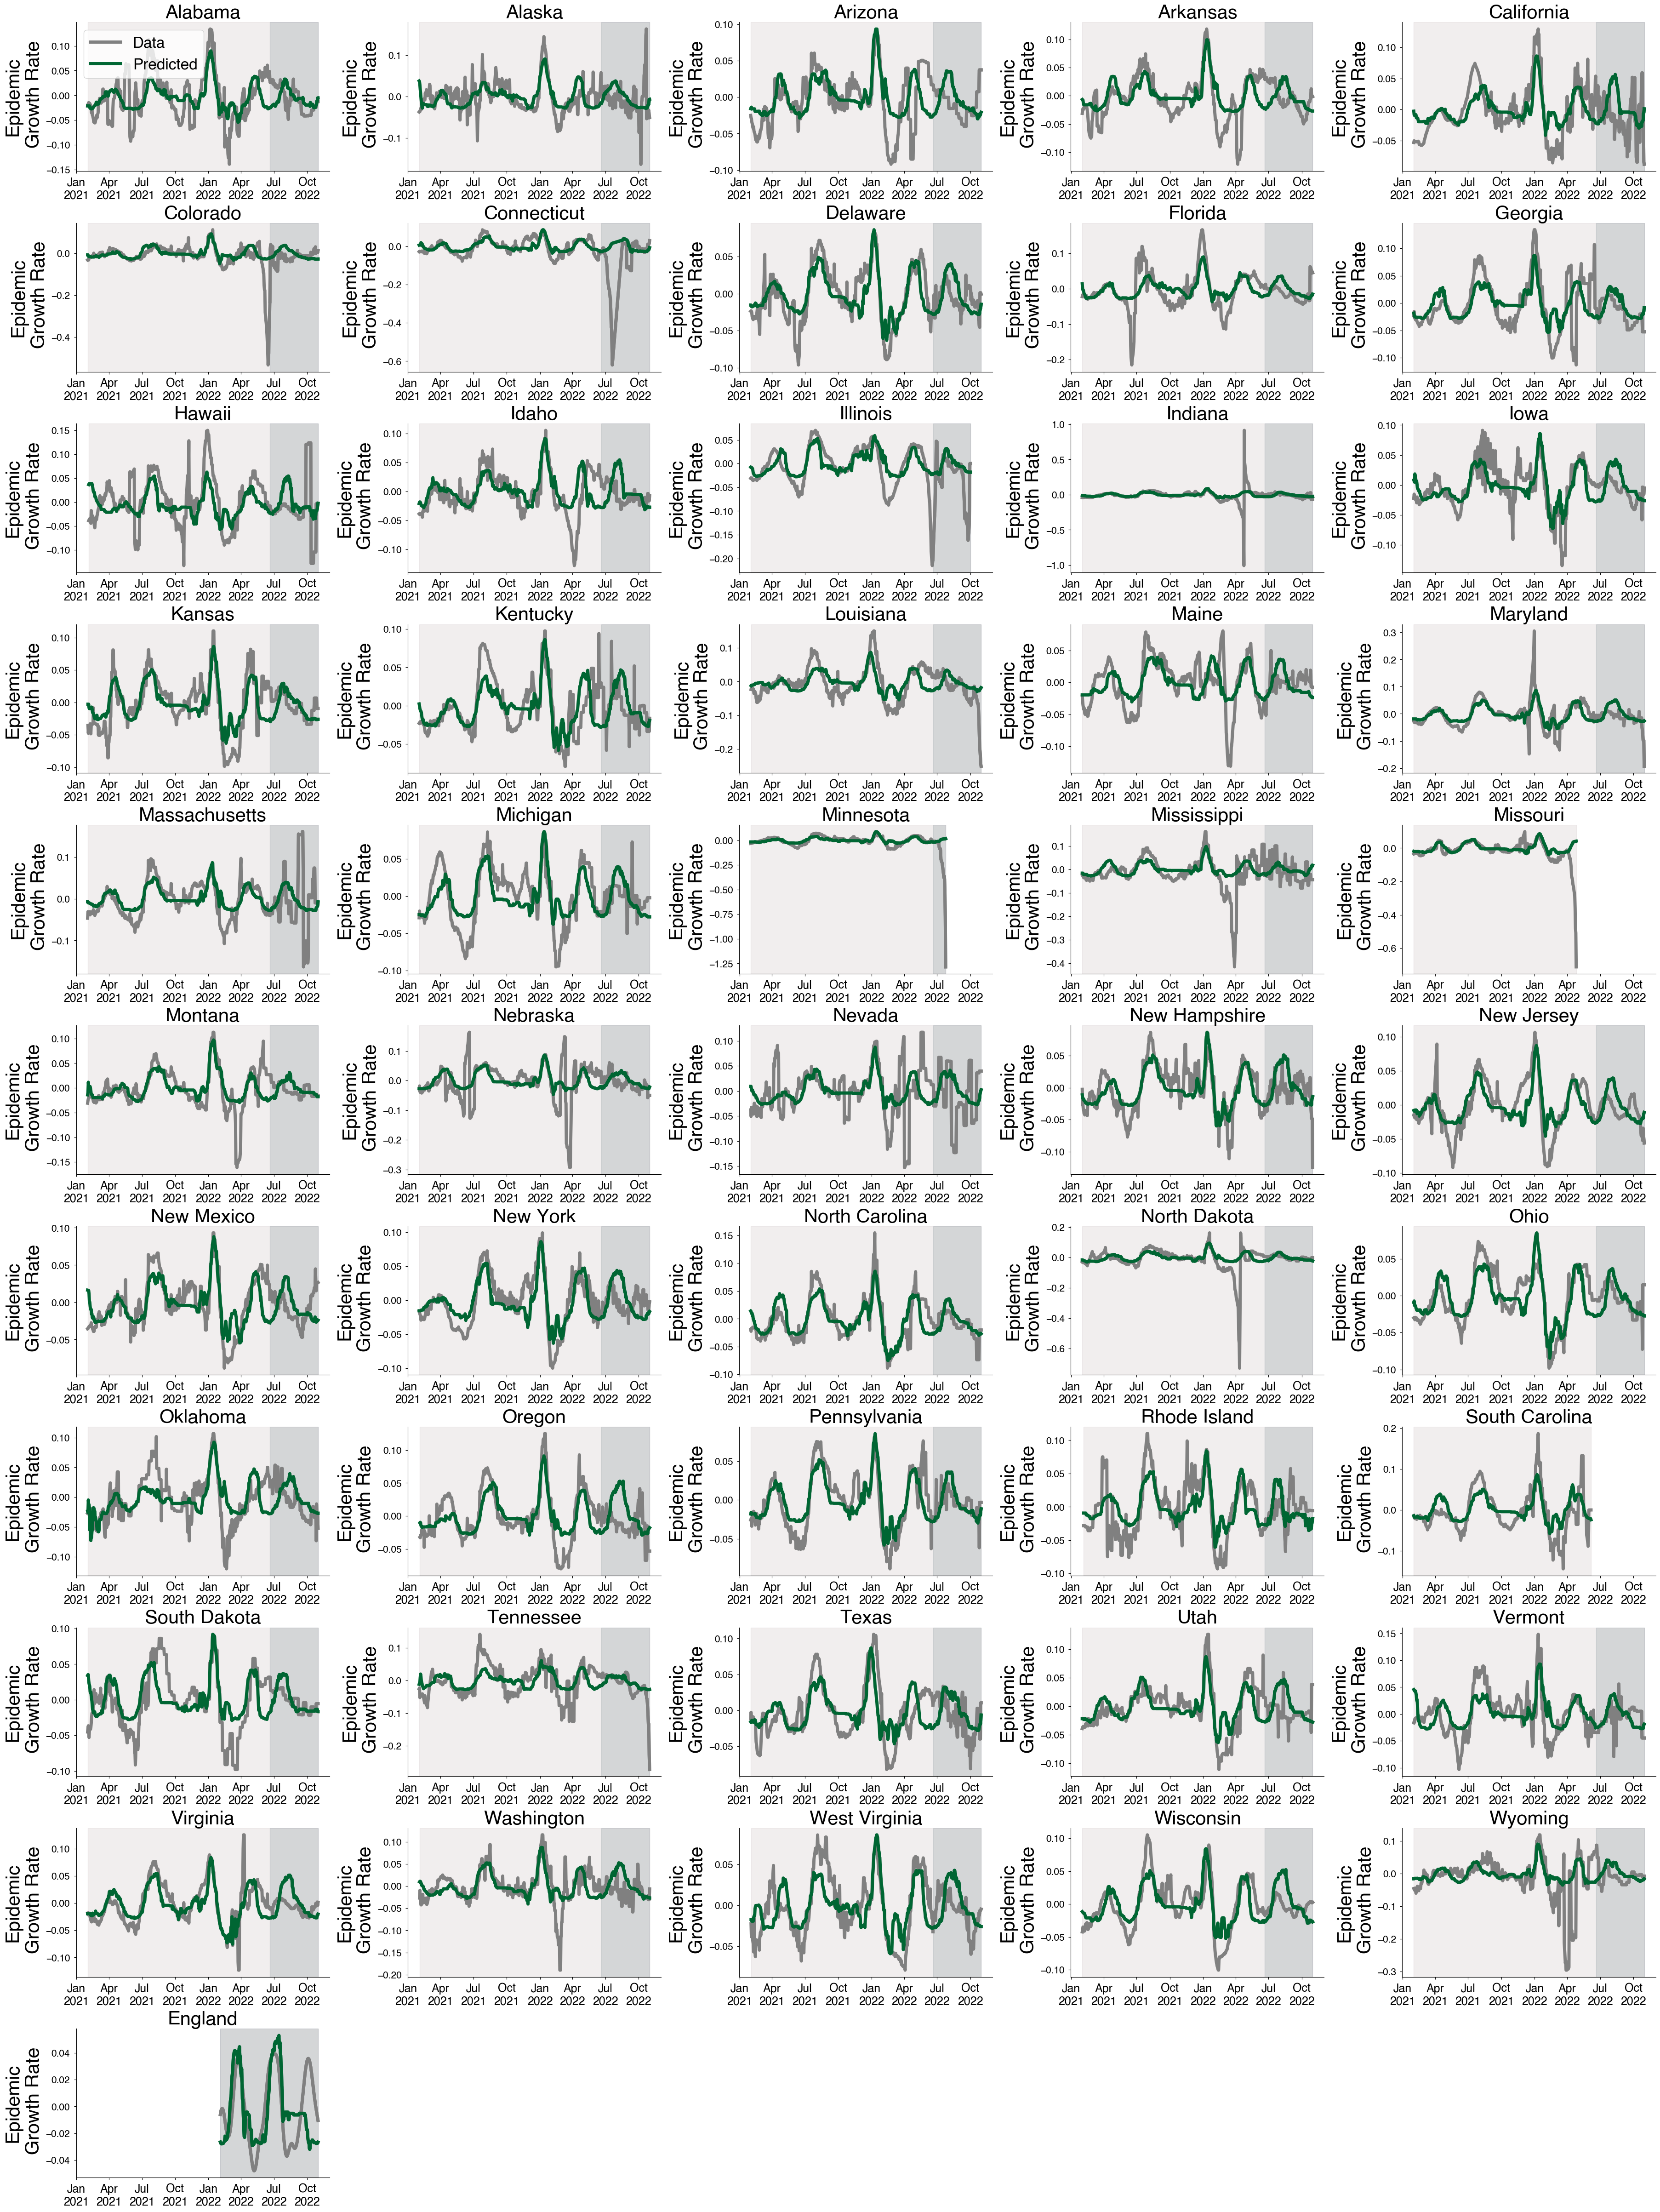

In [16]:
def plot_yeqx(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        return None
    
locations = selective_pressure_df["location"].unique()
fig = plt.figure(figsize=(36, 48), constrained_layout=True)
spec = fig.add_gridspec(ncols=5, nrows=len(locations) // 5 + 1)

for l, loc in enumerate(locations):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        #ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)

    ax.set_ylabel("Epidemic\n Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()

fig.savefig("../manuscript/supplementary_figures/empirical_growth_rate_predictions_all.png")

In [17]:
# Subset locations
locations_subset = ["California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

In [18]:
from scipy import stats

def fit_linear(_x, _y):
    is_finite = ~np.isnan(_x) & ~np.isnan(_y)
    x, y = _x[is_finite], _y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p


/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MAE: 0.01936981924087046
R^2 0.3277893656397744


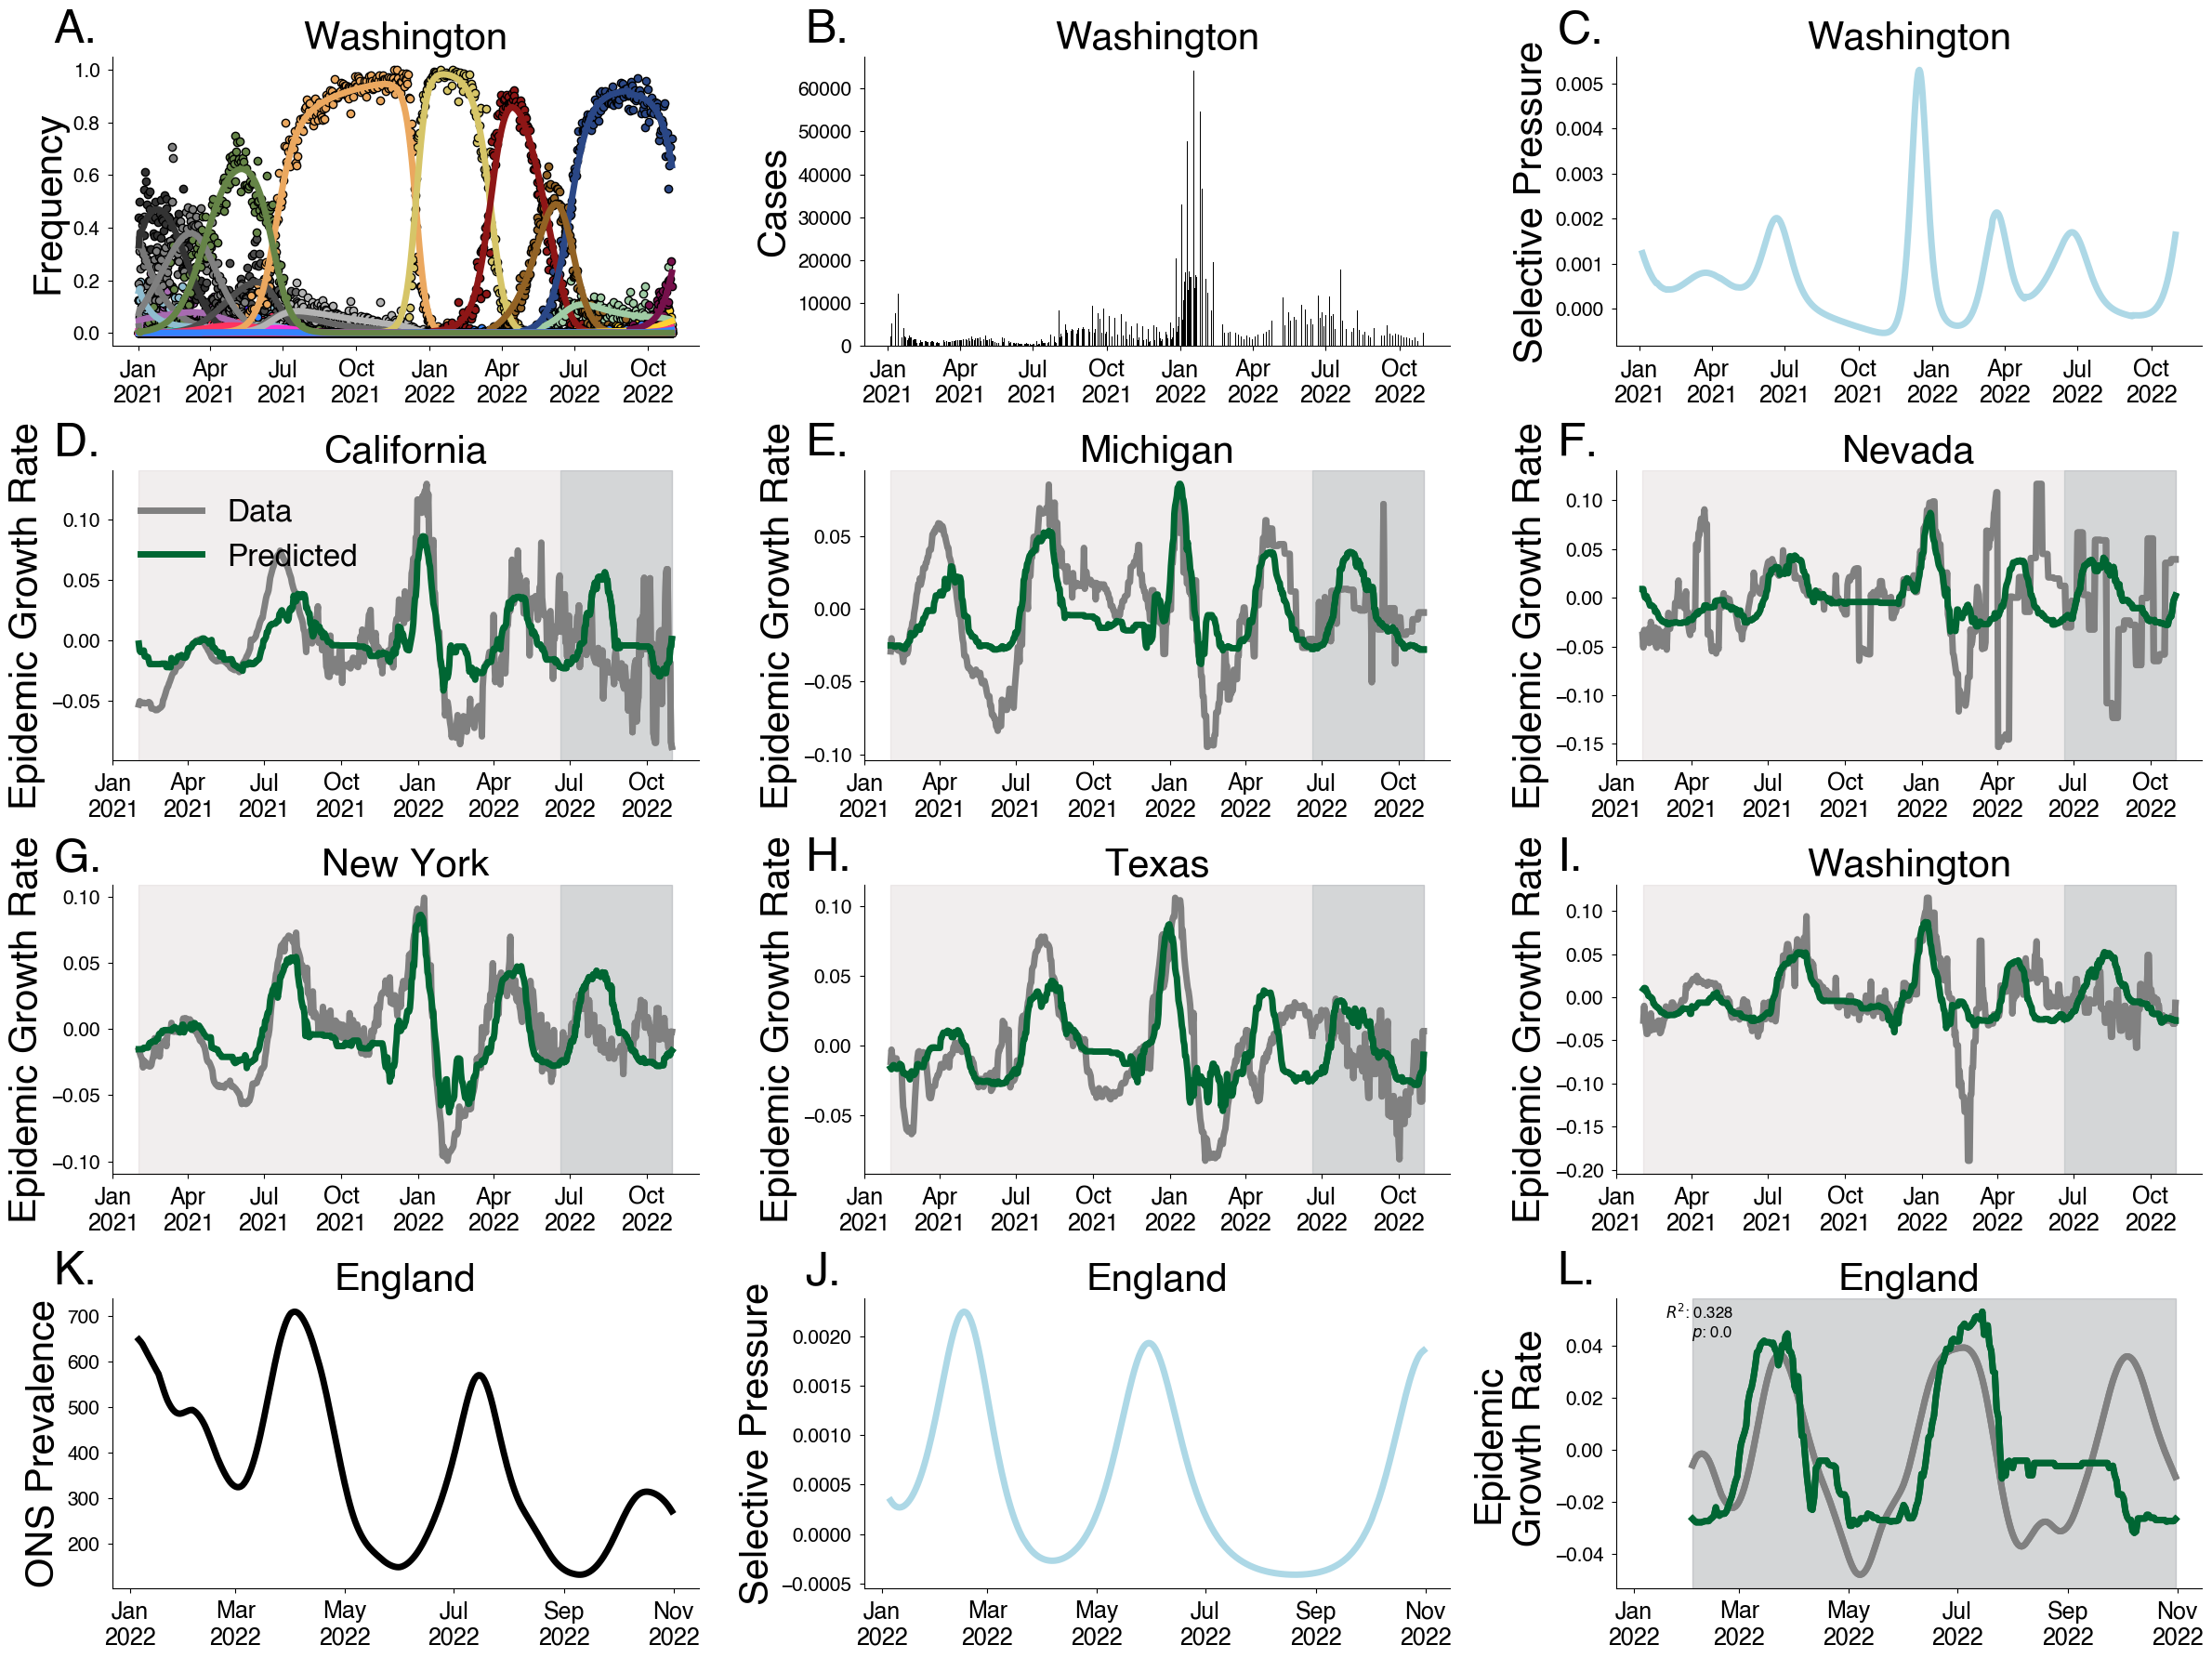

In [19]:
import evofr as ef
from evofr.plotting import FrequencyPlot
#from sklearn.metrics import r2_score

fig = plt.figure(figsize=(24, 18))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 +2)

data = {loc: df for loc, df in selective_pressure_df.groupby("location")}
axes = []

example_state = "Washington"

# Plotting single state as example
ax = fig.add_subplot(spec[0])

# Plotting variant frequencies
with open("../data/posteriors/selective-pressure-analysis/color_map.pkl", 'rb') as f:
    color_map = pickle.load(f)

with open("../data/posteriors/selective-pressure-analysis/example_data.pkl", 'rb') as f:
    example_data = pickle.load(f)
    
example_post = ef.PosteriorHandler(data=example_data).load_posterior(f"../data/posteriors/selective-pressure-analysis/{example_state}.pkl")
var_names = example_post.data.var_names
var_idxs = [v for v in range(len(var_names))]
raw_freq = example_data.seq_counts / example_data.seq_counts.sum(axis=-1)[:, None]
for var_idx, variant in zip(var_idxs, var_names):
    ax.plot(np.array(example_post.data.dates), example_post.samples["freq"][0, :, var_idx], color=color_map[variant])
    ax.scatter(np.array(example_post.data.dates), raw_freq[:, var_idx], color=color_map[variant], ec="k")
                      
ax.set_ylabel("Frequency")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_title("Washington")
axes.append(ax)

# Example cases
ax = fig.add_subplot(spec[1])
ax.bar(data[example_state]["date"], data[example_state]["cases"], color="black")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_ylabel("Cases")
ax.set_title("Washington")
axes.append(ax)

# Example selective pressure
ax = fig.add_subplot(spec[2])
ax.plot(data[example_state]["date"], data[example_state]["selective_pressure"], color="lightblue")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_ylabel("Selective Pressure")
ax.set_title("Washington")
axes.append(ax)

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l+3], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        #ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Epidemic Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend(frameon=False, loc="upper left")
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 1], sharex=None if _l==0 else ax)
    ax.plot(data[loc]["date"], data[loc]["selective_pressure"], color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 0], sharex = ax)    
    ax.plot(data[loc]["date"], data[loc]["smooth_cases"], color="k")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Fit linear model
    xs, ys, r, p = fit_linear(y_test[loc_idx_test].values[:, 0], predictions_test[loc_idx_test])
    test_mae = np.mean(np.abs(y_test[loc_idx_test].values[:, 0] - predictions_test[loc_idx_test]))
    print("MAE:", test_mae)
    print("R^2", r**2)
    
    # Add regression statistics
    stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(5))
    ax.text(0.2, 0.985, stats_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)

    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        #ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Epidemic\n Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
fig.tight_layout()

fig.savefig("../manuscript/figures/selective_pressure_prediction.png")

In [25]:
# Fit linear model
_, _, r_train, _ = fit_linear(y_train.values[:, 0], model.predict(X_train))
print("R^2: Training", r_train**2)

_, _, r_test, _ = fit_linear(y_test.values[:, 0], model.predict(X_test))
print("R^2: Test", r_test**2)

R^2: Training 0.36486103491642596
R^2: Test 0.01288443847752994


In [20]:
def make_summary_table(data):
    df = pd.DataFrame(data)
    # Calculate mean and standard error
    n = len(df)
    summary_df = pd.DataFrame({
        "model": df.columns,
        "mean_error": df.mean(),
        "standard_error": df.std() / np.sqrt(n)
    }).reset_index(drop=True)

    # Generate LaTeX table
    latex_table = summary_df.style.to_latex(
        caption="Model Mean and Standard Error for Cross-Validation Splits",
        label="tab:model_errors",
        column_format="|l|c|c|",  # Adds column separation lines for better aesthetics
    )

    return summary_df, latex_table

summary_df, latex_table = make_summary_table(model_scores)

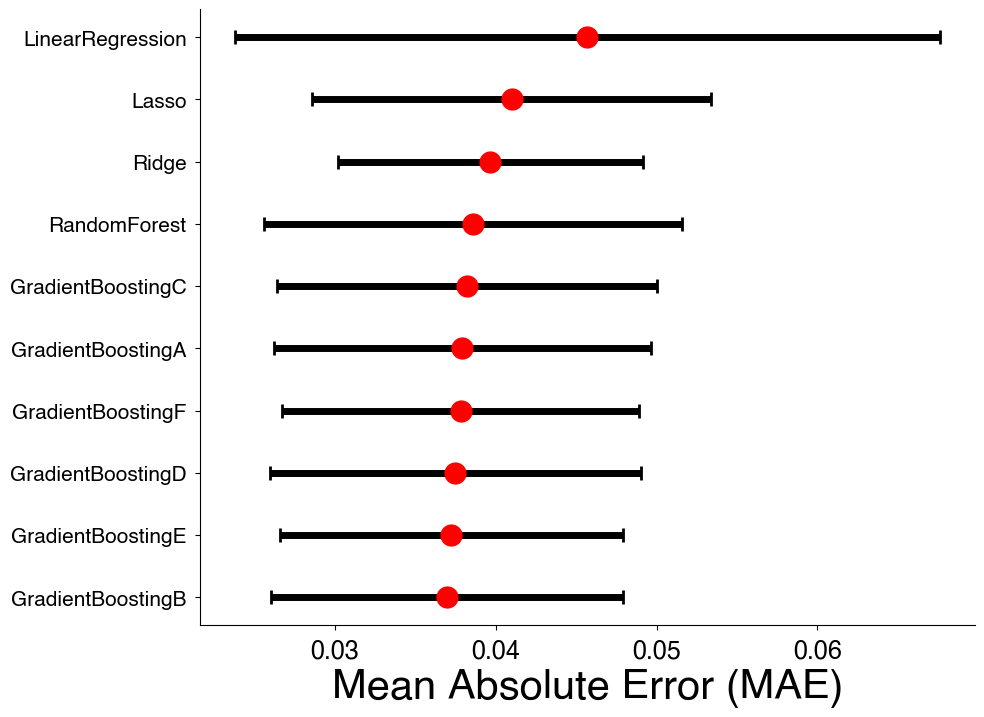

In [21]:
fig = plt.figure(figsize=(10, 8))
spec = fig.add_gridspec(ncols=1, nrows=1)

# Create the main plot area for the error bar plot in a specific grid location
ax = fig.add_subplot(spec[0:2, :])

# Sorting the summary_df by mean_error to order models by mean error
summary_df_sorted = summary_df.sort_values(by="mean_error").reset_index(drop=True)

# Plotting Mean Absolute Error (MAE) with ± 2 standard errors
ax.errorbar(
    summary_df_sorted["mean_error"], 
    summary_df_sorted["model"], 
    xerr=2 * summary_df_sorted["standard_error"], 
    fmt='o', 
    markersize=15,
    capsize=5, 
    capthick=2, 
    ecolor='k',
    color="r"
)
ax.set_yticks(range(len(summary_df_sorted)))
ax.set_yticklabels(summary_df_sorted["model"], ha='right')
ax.set_xlabel("Mean Absolute Error (MAE)")

fig.savefig("../manuscript/supplementary_figures/growth-rate-prediction-model-comparison.png")